# Summarizing Research Outputs - Base dataset

In [56]:
import numpy as np
import pandas as pd
pd.set_option('display.max_columns', None)
import matplotlib.pyplot as plt
import seaborn as sns
import datetime as dt
import time

# import the parquet library
import pyarrow.parquet as pq

# import model libraries
from sklearn.metrics import mean_squared_error, accuracy_score, mean_absolute_error

import statsmodels.api as sm
import statsmodels.formula.api as smf

In [57]:
# load the data base_portfolio_reg1.parquet and base_lvwreturns_reg1.parquet

# portfolios
# regressions
portfolio1 = pd.read_parquet('fin_portfolio_reg1.parquet') # all regressions
portfolio2 = pd.read_parquet('fin_portfolio_class1.parquet') # classification - no Lasso
portfolio3 = pd.read_parquet('fin_portfolio_class2.parquet') # classification - Lasso

portfolio4 = pd.read_parquet('fin_portfolio_reg1_MSE.parquet')
portfolio5 = pd.read_parquet('fin_portfolio_class1_MSE.parquet')
portfolio6 = pd.read_parquet('fin_portfolio_class2_MSE.parquet')


## Prediction Evaluation (MAE, MSE, Accuracy) and Comparison of ML Algorithms

### Decile accuracy

In [58]:
# Assuming original portfolio DataFrames are named as such
dataframes = {
    'portfolio1': portfolio1,
    'portfolio2': portfolio2,
    'portfolio3': portfolio3, 
    'portfolio4': portfolio4,
    'portfolio5': portfolio5,
    'portfolio6': portfolio6 
}

# Loop through the dictionary to drop columns
for name, df in dataframes.items():
    # Find columns that start with "position" or "decile"
    columns_to_drop = [col for col in df.columns if col.startswith('decile')]
    # Drop these columns
    df.drop(columns=columns_to_drop, inplace=True)
    # Update the dictionary with the modified DataFrame
    dataframes[name] = df

# Columns to be dropped
columns_to_drop = ['date', 'RET', 'ME']


# Loop through the dictionary, skipping the first item
for name, df in list(dataframes.items()):  # [1:] skips the first item
    # Check if DataFrame contains the columns to be dropped
    cols_to_drop = [col for col in columns_to_drop if col in df.columns]
    # Drop the columns if present
    if cols_to_drop:
        df.drop(columns=cols_to_drop, inplace=True)


# keep only predictions for the top and bottom deciles
for portfolio_name, df in dataframes.items():
    for col in df.columns:
        # If column does not start with "position_", check for a corresponding "position_" column
        if not col.startswith("position_"):
            position_col = f"position_{col}"
            if position_col in df.columns:
                # Replace model's value with NaN where position is 0
                df.loc[df[position_col] == 0, col] = np.nan
    # Drop columns starting with "position"
    df.drop(columns=[col for col in df.columns if col.startswith("position_")], inplace=True)
    
    # Update the dictionary with the modified dataframe
    dataframes[portfolio_name] = df



# Now, dataframes['portfolio1'], dataframes['portfolio2'], and dataframes['portfolio3'] have the columns dropped
# If you need to work directly with the modified portfolio1, portfolio2, and portfolio3, you can extract them like so:
portfolio1, portfolio2, portfolio3, portfolio4, portfolio5, portfolio6 = dataframes.values()

In [59]:
metrics_decile = pd.DataFrame(columns=['Accuracy', 'MAE', 'MSE'])

def calculate_accuracy(y_true, y_pred):
    # Exclude NaN values from both y_true and y_pred
    valid_indices = ~y_pred.isna()
    y_true_valid = y_true[valid_indices]
    y_pred_valid = y_pred[valid_indices]
    y_pred_class = (y_pred_valid >= 0.5).astype(int)
    accuracy = np.mean(y_true_valid == y_pred_class)
    return accuracy

# Loop over each portfolio DataFrame
for name, portfolio in dataframes.items():
    y = portfolio['y']
    for column in portfolio.columns:
        if column == 'y':
            continue  # Skip the 'y' column

        # Calculate metrics, excluding NaN values
        valid_indices = ~portfolio[column].isna()
        if valid_indices.sum() > 0:  # Proceed only if there are non-NaN predictions
            accuracy = calculate_accuracy(y[valid_indices], portfolio[column][valid_indices])
            mae = mean_absolute_error(y[valid_indices], portfolio[column][valid_indices])
            mse = mean_squared_error(y[valid_indices], portfolio[column][valid_indices])

            # Store metrics in the DataFrame
            metrics_decile.loc[column] = [accuracy, mae, mse]
        else:
            # Handle the case where all predictions are NaN
            metrics_decile.loc[column] = [np.nan, np.nan, np.nan]

# Display the DataFrame with the calculated metrics
metrics_decile.head(20)

,Accuracy,MAE,MSE
ols_default,0.981910,0.216044,0.179753
ridge_reg_roll5,0.983573,0.200164,0.081897
lasso_reg_roll5,0.974223,0.315513,0.110080
DT_reg_roll5,0.973323,0.039291,0.019050
RF_reg_roll5,0.973936,0.036899,0.018137
base_ols_default,0.983888,0.209774,0.085873
ridge_clas_roll5,0.995248,0.008300,0.003839
DT_class_roll5,0.946089,0.088545,0.043337
RF_class_roll5,0.998675,0.035036,0.002771
lasso_clas_roll5,0.994813,0.010883,0.004353


In [60]:
# display only rows where index = 'ridge_reg_roll5','ridge_clas_roll5_AC', 'ridge_clas_roll5_decAC', 'RF_class_roll5_AC', 'RF_reg_exp', 'ols_default'
print_metrics = ['base_ols_default', 'RF_class_roll5' , 'ridge_reg_roll5',  'RF_class_roll5_MSE', 'lasso_clas_roll5', 'DT_reg_roll5_MSE', 'RF_reg_roll5_MSE']

metrics_decile[['Accuracy', 'MSE']].loc[print_metrics].sort_values(by='Accuracy', ascending=False).head(10)


,Accuracy,MSE
RF_class_roll5_MSE,0.998701,0.002091
RF_class_roll5,0.998675,0.002771
lasso_clas_roll5,0.994813,0.004353
base_ols_default,0.983888,0.085873
ridge_reg_roll5,0.983573,0.081897
RF_reg_roll5_MSE,0.983315,0.011530
DT_reg_roll5_MSE,0.978905,0.014812


In [61]:
# Iterate over the row labels (index) of the metrics_decile DataFrame
for label in metrics_decile.index:
    # Determine 'type'
    if "reg" in label:
        metrics_decile.loc[label, 'type'] = 'reg'
    elif "clas" in label:
        metrics_decile.loc[label, 'type'] = 'class'
    elif "ols" in label:
        metrics_decile.loc[label, 'type'] = 'reg'
    else:
        metrics_decile.loc[label, 'type'] = 'class'

    
    # Determine 'metric'
    if label.endswith("MSE"):
        metrics_decile.loc[label, 'metric'] = 'mse'
    else:
        metrics_decile.loc[label, 'metric'] = 'acc'

    # Determine 'Algorithm'
    if "ridge" in label:
        metrics_decile.loc[label, 'algorithm'] = 'ridge'
    elif "DT" in label:
        metrics_decile.loc[label, 'algorithm'] = 'DT'
    elif "RF" in label:
        metrics_decile.loc[label, 'algorithm'] = 'RF'
    else:
        metrics_decile.loc[label, 'algorithm'] = 'other'

# Now, metrics_decile contains the additional categorizations based on the index names.
metrics_decile.sort_values(by='Accuracy', ascending=False, inplace=True)
metrics_decile.head(20)

,Accuracy,MAE,MSE,type,metric,algorithm
RF_class_roll5_MSE,0.998701,0.026905,0.002091,class,mse,RF
RF_class_roll5,0.998675,0.035036,0.002771,class,acc,RF
ridge_clas_roll5_MSE,0.996089,0.005358,0.003620,class,mse,ridge
lasso_clas_roll5_MSE,0.995630,0.005578,0.004008,class,mse,other
ridge_clas_roll5,0.995248,0.008300,0.003839,class,acc,ridge
lasso_clas_roll5,0.994813,0.010883,0.004353,class,acc,other
base_ols_default,0.983888,0.209774,0.085873,reg,acc,other
ridge_reg_roll5,0.983573,0.200164,0.081897,reg,acc,ridge
RF_reg_roll5_MSE,0.983315,0.023572,0.011530,reg,mse,RF
ols_default,0.981910,0.216044,0.179753,reg,acc,other


In [62]:
# First, generate dummy variables for categorical predictors
X = pd.get_dummies(metrics_decile[['type', 'metric', 'algorithm']], drop_first=True)
# Add a constant to the model (intercept)
X = sm.add_constant(X)

# Model 1: Accuracy as the dependent variable
y_accuracy = metrics_decile['Accuracy']
model_accuracy = sm.OLS(y_accuracy, X).fit()

# Model 2: MSE as the dependent variable
y_mse = metrics_decile['MSE']
model_mse = sm.OLS(y_mse, X).fit()

# Print the summary tables of both regressions
print("OLS Regression Model Summary (Dependent Variable: Accuracy)")
print(model_accuracy.summary())
print("\nOLS Regression Model Summary (Dependent Variable: MSE)")
print(model_mse.summary())

OLS Regression Model Summary (Dependent Variable: Accuracy)
                            OLS Regression Results                            
Dep. Variable:               Accuracy   R-squared:                       0.544
Model:                            OLS   Adj. R-squared:                  0.354
Method:                 Least Squares   F-statistic:                     2.862
Date:                Thu, 07 Mar 2024   Prob (F-statistic):             0.0629
Time:                        15:15:06   Log-Likelihood:                 60.287
No. Observations:                  18   AIC:                            -108.6
Df Residuals:                      12   BIC:                            -103.2
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                      coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------

c:\Users\tomta\anaconda3\lib\site-packages\scipy\stats\_stats_py.py:1736: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=18
  warnings.warn("kurtosistest only valid for n>=20 ... continuing "
c:\Users\tomta\anaconda3\lib\site-packages\scipy\stats\_stats_py.py:1736: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=18
  warnings.warn("kurtosistest only valid for n>=20 ... continuing "


In [63]:
# print average accuracy grouped by type and method
print(metrics_decile.groupby(['type', 'metric'])['Accuracy'].mean())

type   metric
class  acc       0.983706
       mse       0.992215
reg    acc       0.978475
       mse       0.979375
Name: Accuracy, dtype: float64


### Overall Accuracy

Drop useless columns from portfolio dataframes.

In [64]:
# load the data base_portfolio_reg1.parquet and base_lvwreturns_reg1.parquet

# load the data base_portfolio_reg1.parquet and base_lvwreturns_reg1.parquet

# portfolios
# regressions
portfolio1 = pd.read_parquet('fin_portfolio_reg1.parquet') # all regressions
portfolio2 = pd.read_parquet('fin_portfolio_class1.parquet') # classification - no Lasso
portfolio3 = pd.read_parquet('fin_portfolio_class2.parquet') # classification - Lasso

portfolio4 = pd.read_parquet('fin_portfolio_reg1_MSE.parquet')
portfolio5 = pd.read_parquet('fin_portfolio_class1_MSE.parquet')
portfolio6 = pd.read_parquet('fin_portfolio_class2_MSE.parquet')

In [65]:
# Assuming your DataFrames are already defined as portfolio1, portfolio2, and portfolio3
# Create a dictionary mapping names to DataFrame objects
dataframes = {
    'portfolio1': portfolio1,
    'portfolio2': portfolio2,
    'portfolio3': portfolio3, 
    'portfolio4': portfolio4,
    'portfolio5': portfolio5,
    'portfolio6': portfolio6
}

# Loop through the dictionary to drop columns
for name, df in dataframes.items():
    # Find columns that start with "position" or "decile"
    columns_to_drop = [col for col in df.columns if col.startswith('position') or col.startswith('decile')]
    # Drop these columns
    df.drop(columns=columns_to_drop, inplace=True)
    # Update the dictionary with the modified DataFrame
    dataframes[name] = df

# Columns to be dropped
columns_to_drop = ['date', 'RET', 'ME']


# Loop through the dictionary, skipping the first item
for name, df in list(dataframes.items()):  # [1:] skips the first item
    # Check if DataFrame contains the columns to be dropped
    cols_to_drop = [col for col in columns_to_drop if col in df.columns]
    # Drop the columns if present
    if cols_to_drop:
        df.drop(columns=cols_to_drop, inplace=True)


# Now, dataframes['portfolio1'], dataframes['portfolio2'], and dataframes['portfolio3'] have the columns dropped
# If you need to work directly with the modified portfolio1, portfolio2, and portfolio3, you can extract them like so:
portfolio1, portfolio2, portfolio3, portfolio4, portfolio5, portfolio6 = dataframes.values()


In [66]:
# Initialize a DataFrame to store the metrics
metrics_df = pd.DataFrame(columns=['Accuracy', 'MAE', 'MSE'])

# Function to calculate accuracy assuming binary classification with threshold 0.5
def calculate_accuracy(y_true, y_pred):
    y_pred_class = (y_pred >= 0.5).astype(int)
    accuracy = np.mean(y_true == y_pred_class)
    return accuracy

# Loop over each portfolio DataFrame
for name, portfolio in dataframes.items():
    for column in portfolio.columns:
        if column == 'y' or column in metrics_df.index:
            continue  # Skip the 'y' column and any column already processed

        # Calculate metrics
        accuracy = calculate_accuracy(portfolio['y'], portfolio[column])
        mae = mean_absolute_error(portfolio['y'], portfolio[column])
        mse = mean_squared_error(portfolio['y'], portfolio[column])

        # Store metrics in the DataFrame
        metrics_df.loc[column] = [accuracy, mae, mse]

# Display the DataFrame with the calculated metrics
metrics_df.head()


,Accuracy,MAE,MSE
ols_default,0.863516,0.331614,0.156884
ridge_reg_roll5,0.828993,0.342293,0.150194
lasso_reg_roll5,0.774626,0.423916,0.190628
DT_reg_roll5,0.970240,0.047683,0.023266
RF_reg_roll5,0.970277,0.047653,0.023104


In [67]:
metrics_df[['Accuracy', 'MSE']].loc[print_metrics].sort_values(by='Accuracy', ascending=False).head(10)

,Accuracy,MSE
RF_reg_roll5_MSE,0.971525,0.021530
RF_class_roll5_MSE,0.971152,0.030291
RF_class_roll5,0.971124,0.033426
DT_reg_roll5_MSE,0.970224,0.022646
lasso_clas_roll5,0.908012,0.066133
ridge_reg_roll5,0.828993,0.150194
base_ols_default,0.825230,0.150978


In [68]:
# Iterate over the row labels (index) of the DataFrame
for label in metrics_df.index:
    # Determine 'algorithm'
    if "reg" in label:
        metrics_df.loc[label, 'type'] = 'reg'
    elif "clas" in label:
        metrics_df.loc[label, 'type'] = 'class'
    elif "ols" in label:
        metrics_df.loc[label, 'type'] = 'reg'
    else:
        metrics_df.loc[label, 'type'] = 'class'
    
    
    # Determine 'metric'
    if label.endswith("MSE"):
        metrics_df.loc[label, 'metric'] = 'mse'
    else:
        metrics_df.loc[label, 'metric'] = 'acc'

    # Determine 'Algorithm'
    if "ridge" in label:
        metrics_df.loc[label, 'algorithm'] = 'ridge'
    elif "DT" in label:
        metrics_df.loc[label, 'algorithm'] = 'DT'
    elif "RF" in label:
        metrics_df.loc[label, 'algorithm'] = 'RF'
    else:
        metrics_df.loc[label, 'algorithm'] = 'other'


In [69]:
# sort the dataframe by MSE

metrics_df.sort_values(by='Accuracy', ascending=False, inplace=True)

metrics_df.head(20)

,Accuracy,MAE,MSE,type,metric,algorithm
RF_reg_roll5_MSE,0.971525,0.045235,0.021530,reg,mse,RF
RF_class_roll5_MSE,0.971152,0.111654,0.030291,class,mse,RF
RF_class_roll5,0.971124,0.126338,0.033426,class,acc,RF
RF_reg_roll5,0.970277,0.047653,0.023104,reg,acc,RF
DT_reg_roll5,0.970240,0.047683,0.023266,reg,acc,DT
DT_reg_roll5_MSE,0.970224,0.045274,0.022646,reg,mse,DT
DT_class_roll5_MSE,0.969930,0.045447,0.022760,class,mse,DT
DT_class_roll5,0.960374,0.066410,0.032104,class,acc,DT
lasso_clas_roll5_MSE,0.948085,0.092048,0.041070,class,mse,other
ridge_clas_roll5_MSE,0.940965,0.105084,0.046147,class,mse,ridge


In [70]:
# First, generate dummy variables for categorical predictors
X = pd.get_dummies(metrics_df[['type', 'metric', 'algorithm']], drop_first=True)
# Add a constant to the model (intercept)
X = sm.add_constant(X)

# Model 1: Accuracy as the dependent variable
y_accuracy = metrics_df['Accuracy']
model_tot_accuracy = sm.OLS(y_accuracy, X).fit()

# Model 2: MSE as the dependent variable
y_mse = metrics_df['MSE']
model_tot_mse = sm.OLS(y_mse, X).fit()

# Print the summary tables of both regressions
print("OLS Regression Model Summary (Dependent Variable: Accuracy)")
print(model_tot_accuracy.summary())


OLS Regression Model Summary (Dependent Variable: Accuracy)
                            OLS Regression Results                            
Dep. Variable:               Accuracy   R-squared:                       0.774
Model:                            OLS   Adj. R-squared:                  0.679
Method:                 Least Squares   F-statistic:                     8.207
Date:                Thu, 07 Mar 2024   Prob (F-statistic):            0.00142
Time:                        15:15:12   Log-Likelihood:                 35.677
No. Observations:                  18   AIC:                            -59.35
Df Residuals:                      12   BIC:                            -54.01
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                      coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------

c:\Users\tomta\anaconda3\lib\site-packages\scipy\stats\_stats_py.py:1736: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=18
  warnings.warn("kurtosistest only valid for n>=20 ... continuing "


In [71]:
print("\nOLS Regression Model Summary (Dependent Variable: MSE)")
print(model_tot_mse.summary())


OLS Regression Model Summary (Dependent Variable: MSE)
                            OLS Regression Results                            
Dep. Variable:                    MSE   R-squared:                       0.774
Model:                            OLS   Adj. R-squared:                  0.680
Method:                 Least Squares   F-statistic:                     8.215
Date:                Thu, 07 Mar 2024   Prob (F-statistic):            0.00142
Time:                        15:15:12   Log-Likelihood:                 37.583
No. Observations:                  18   AIC:                            -63.17
Df Residuals:                      12   BIC:                            -57.82
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                      coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------

c:\Users\tomta\anaconda3\lib\site-packages\scipy\stats\_stats_py.py:1736: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=18
  warnings.warn("kurtosistest only valid for n>=20 ... continuing "


## Portfolio Comparison in terms of returns

In [72]:
# returns
returns1 = pd.read_parquet('fin_lvwreturns_reg1.parquet') # regression
returns2 = pd.read_parquet('fin_lvwreturns_class1.parquet')  # no Lasso
returns3 = pd.read_parquet('fin_lvwreturns_class2.parquet') # Lasso

returns4 = pd.read_parquet('fin_lvwreturns_reg1_MSE.parquet')
returns5 = pd.read_parquet('fin_lvwreturns_class1_MSE.parquet')
returns6 = pd.read_parquet('fin_lvwreturns_class2_MSE.parquet')


### Handling the files

In [73]:
# drop the Mkt column from returns except for returns1

n_files = 6

# for "returns{i]" drop the Mkt column
for i in range(2, n_files + 1):
    returns = globals()[f'returns{i}']
    returns = returns.drop('Mkt', axis=1)
    globals()[f'returns{i}'] = returns

In [74]:
from functools import reduce

# Assuming your DataFrames are already loaded as returns1, returns2, ..., returns11
dataframes = [returns1, returns2, returns3, returns4, returns5, returns6]

# Use functools.reduce to merge all DataFrames on 'date'
log_ret = reduce(lambda left, right: pd.merge(left, right, on='date', how='inner'), dataframes)

# Check the first few rows of the merged DataFrame
log_ret.head()


,date,vwreturn_ols_default_x,vwreturn_ridge_reg_roll5,vwreturn_lasso_reg_roll5,vwreturn_DT_reg_roll5,vwreturn_RF_reg_roll5,Mkt,vwreturn_base_ols_default_x,vwreturn_ols_default_y,vwreturn_ridge_clas_roll5,vwreturn_DT_class_roll5,vwreturn_RF_class_roll5,vwreturn_lasso_clas_roll5,vwreturn_ols_default_x,vwreturn_ridge_reg_roll5_MSE,vwreturn_lasso_reg_roll5_MSE,vwreturn_DT_reg_roll5_MSE,vwreturn_RF_reg_roll5_MSE,vwreturn_base_ols_default_y,vwreturn_ols_default_y,vwreturn_ridge_clas_roll5_MSE,vwreturn_DT_class_roll5_MSE,vwreturn_RF_class_roll5_MSE,vwreturn_lasso_clas_roll5_MSE
0,1976-01-31,0.029989,0.031739,-0.089872,-0.001282,-0.001266,0.118938,0.038773,0.029989,0.022233,-0.001282,0.023075,0.023404,0.029989,0.027591,-0.089872,-0.001282,-0.001266,0.038773,0.029989,0.021843,-0.001282,0.023075,-0.001181
1,1976-02-29,0.015146,0.014469,0.008801,-0.009967,-0.009967,0.006578,0.022116,0.015146,0.022461,0.024578,0.019523,0.026914,0.015146,0.023073,0.008801,-0.009967,-0.009967,0.022116,0.015146,0.013786,-0.009967,0.019523,0.003713
2,1976-03-31,0.010442,0.010468,0.005295,0.005930,0.008891,0.026837,0.011821,0.010442,0.012734,0.013700,0.013366,0.005123,0.010442,0.011536,0.005295,0.005930,0.006998,0.011821,0.010442,0.009928,0.005930,0.013366,0.002113
3,1976-04-30,0.010628,0.006661,0.002824,0.026588,0.026599,-0.010758,0.007940,0.010628,0.007104,0.026500,0.010222,0.002816,0.010628,0.010539,0.002824,0.026588,0.026415,0.007940,0.010628,0.007092,0.026588,0.010222,0.002852
4,1976-05-31,0.019840,0.019417,0.005775,0.025091,0.025091,-0.009747,0.019032,0.019840,0.017543,0.025046,0.016657,0.017319,0.019840,0.019873,0.005775,0.025091,0.025063,0.019032,0.019840,0.016566,0.025091,0.016657,0.016685


In [75]:
# Filter columns that do not end with "_x", "_y", or "_z"
filtered_columns = [col for col in log_ret.columns if not col.endswith(('_y', '_z'))]

# Select only the filtered columns from the DataFrame

log_ret = log_ret[filtered_columns]

# drop columns with duplicate names
log_ret = log_ret.loc[:,~log_ret.columns.duplicated()]


print(log_ret.columns)

Index(['date', 'vwreturn_ols_default_x', 'vwreturn_ridge_reg_roll5',
       'vwreturn_lasso_reg_roll5', 'vwreturn_DT_reg_roll5',
       'vwreturn_RF_reg_roll5', 'Mkt', 'vwreturn_base_ols_default_x',
       'vwreturn_ridge_clas_roll5', 'vwreturn_DT_class_roll5',
       'vwreturn_RF_class_roll5', 'vwreturn_lasso_clas_roll5',
       'vwreturn_ridge_reg_roll5_MSE', 'vwreturn_lasso_reg_roll5_MSE',
       'vwreturn_DT_reg_roll5_MSE', 'vwreturn_RF_reg_roll5_MSE',
       'vwreturn_ridge_clas_roll5_MSE', 'vwreturn_DT_class_roll5_MSE',
       'vwreturn_RF_class_roll5_MSE', 'vwreturn_lasso_clas_roll5_MSE'],
      dtype='object')


In [76]:
# Rename columns in 'log_ret' DataFrame
log_ret.rename(columns={col: col.replace('vwreturn', 'l') for col in log_ret.columns}, inplace=True)

log_ret.rename(columns={col: col.replace('_x', '') for col in log_ret.columns}, inplace=True)

# rename 'Mkt' column to 'l_Mkt'
log_ret.rename(columns={'Mkt': 'l_Mkt'}, inplace=True)

# Check the updated column names
print(log_ret.columns)

Index(['date', 'l_ols_default', 'l_ridge_reg_roll5', 'l_lasso_reg_roll5',
       'l_DT_reg_roll5', 'l_RF_reg_roll5', 'l_Mkt', 'l_base_ols_default',
       'l_ridge_clas_roll5', 'l_DT_class_roll5', 'l_RF_class_roll5',
       'l_lasso_clas_roll5', 'l_ridge_reg_roll5_MSE', 'l_lasso_reg_roll5_MSE',
       'l_DT_reg_roll5_MSE', 'l_RF_reg_roll5_MSE', 'l_ridge_clas_roll5_MSE',
       'l_DT_class_roll5_MSE', 'l_RF_class_roll5_MSE',
       'l_lasso_clas_roll5_MSE'],
      dtype='object')


In [77]:
# calculate cumulative sum of each column except for the date column and store in a new DataFrame cum_log_ret, keep the date column
log_ret.sort_values('date', inplace=True)
log_ret.set_index('date', inplace=True)

cum_log_ret = log_ret.cumsum()
cum_log_ret.head()

,l_ols_default,l_ridge_reg_roll5,l_lasso_reg_roll5,l_DT_reg_roll5,l_RF_reg_roll5,l_Mkt,l_base_ols_default,l_ridge_clas_roll5,l_DT_class_roll5,l_RF_class_roll5,l_lasso_clas_roll5,l_ridge_reg_roll5_MSE,l_lasso_reg_roll5_MSE,l_DT_reg_roll5_MSE,l_RF_reg_roll5_MSE,l_ridge_clas_roll5_MSE,l_DT_class_roll5_MSE,l_RF_class_roll5_MSE,l_lasso_clas_roll5_MSE
date,,,,,,,,,,,,,,,,,,,
1976-01-31,0.029989,0.031739,-0.089872,-0.001282,-0.001266,0.118938,0.038773,0.022233,-0.001282,0.023075,0.023404,0.027591,-0.089872,-0.001282,-0.001266,0.021843,-0.001282,0.023075,-0.001181
1976-02-29,0.045135,0.046209,-0.081070,-0.011250,-0.011234,0.125516,0.060889,0.044694,0.023296,0.042599,0.050318,0.050664,-0.081070,-0.011250,-0.011234,0.035629,-0.011250,0.042599,0.002532
1976-03-31,0.055577,0.056677,-0.075775,-0.005320,-0.002343,0.152353,0.072710,0.057428,0.036996,0.055965,0.055441,0.062200,-0.075775,-0.005320,-0.004236,0.045557,-0.005320,0.055965,0.004645
1976-04-30,0.066205,0.063338,-0.072951,0.021268,0.024256,0.141595,0.080651,0.064532,0.063496,0.066186,0.058257,0.072739,-0.072951,0.021268,0.022179,0.052649,0.021268,0.066186,0.007497
1976-05-31,0.086045,0.082755,-0.067176,0.046359,0.049346,0.131848,0.099683,0.082074,0.088542,0.082844,0.075576,0.092612,-0.067176,0.046359,0.047242,0.069215,0.046359,0.082844,0.024182


### What methods perform the best

In [78]:
# calculate cumulative sum of each column except for the date column and store in a new DataFrame and keep only the last row
final_log_ret = cum_log_ret.iloc[-1]
final_log_ret.head() 

l_ols_default         9.263265
l_ridge_reg_roll5     9.476089
l_lasso_reg_roll5     2.577009
l_DT_reg_roll5       12.263309
l_RF_reg_roll5       13.113802
Name: 2022-07-31 00:00:00, dtype: float64

In [79]:
final_log_ret.tail() 

l_RF_reg_roll5_MSE        13.388279
l_ridge_clas_roll5_MSE     4.579795
l_DT_class_roll5_MSE      12.363530
l_RF_class_roll5_MSE       7.959827
l_lasso_clas_roll5_MSE     3.228421
Name: 2022-07-31 00:00:00, dtype: float64

In [80]:
# Convert final_log_ret Series to DataFrame and reset index
final_log_ret_df = final_log_ret.to_frame().reset_index()

# Rename the columns
final_log_ret_df.columns = ['model', 'total_cum_logret']

# Sort the DataFrame by 'total_cum_logret' in descending order
final_log_ret_df.sort_values(by='total_cum_logret', ascending=False, inplace=True)

# Check the first few rows of the updated DataFrame
print(final_log_ret_df.head())


                   model  total_cum_logret
14    l_RF_reg_roll5_MSE         13.388279
4         l_RF_reg_roll5         13.113802
16  l_DT_class_roll5_MSE         12.363530
13    l_DT_reg_roll5_MSE         12.362625
3         l_DT_reg_roll5         12.263309


In [81]:
# Add 'Type' column
final_log_ret_df['Type'] = final_log_ret_df['model'].apply(
    lambda x: 'reg' if 'reg' in x else ('class' if 'clas' in x else 'other')
)


# Add 'Metric' column
final_log_ret_df['Metric'] = final_log_ret_df['model'].apply(
    lambda x: 'mse' if x.endswith('MSE') else 'acc'
)

# Add 'Algorithm' column
final_log_ret_df['Algorithm'] = final_log_ret_df['model'].apply(
    lambda x: 'ridge' if 'ridge' in x else (
        'DT' if 'DT' in x else (
            'RF' if 'RF' in x else 'other'
        )
    )
)

# Check the first few rows to verify the new columns
final_log_ret_df.head()


,model,total_cum_logret,Type,Metric,Algorithm
14,l_RF_reg_roll5_MSE,13.388279,reg,mse,RF
4,l_RF_reg_roll5,13.113802,reg,acc,RF
16,l_DT_class_roll5_MSE,12.363530,class,mse,DT
13,l_DT_reg_roll5_MSE,12.362625,reg,mse,DT
3,l_DT_reg_roll5,12.263309,reg,acc,DT


In [82]:
# change the value of "Algoithm" column to reg if value in model column contains "ols"
final_log_ret_df.loc[final_log_ret_df['model'].str.contains('ols'), 'Algorithm'] = 'ols'
final_log_ret_df.loc[final_log_ret_df['model'].str.contains('ols'), 'Type'] = 'reg'

# change the value of "Algoithm" column to class if value in model column contains "logit"
final_log_ret_df.loc[final_log_ret_df['model'].str.contains('logit'), 'Type'] = 'class'
final_log_ret_df.loc[final_log_ret_df['model'].str.contains('logit'), 'Algorithm'] = 'logit'

In [83]:
# sort the final_log_ret_df DataFrame by 'total_cum_logret' in descending order

final_log_ret_df.sort_values('total_cum_logret', ascending=False, inplace=True)

final_log_ret_df.head(10)

,model,total_cum_logret,Type,Metric,Algorithm
14,l_RF_reg_roll5_MSE,13.388279,reg,mse,RF
4,l_RF_reg_roll5,13.113802,reg,acc,RF
16,l_DT_class_roll5_MSE,12.363530,class,mse,DT
13,l_DT_reg_roll5_MSE,12.362625,reg,mse,DT
3,l_DT_reg_roll5,12.263309,reg,acc,DT
1,l_ridge_reg_roll5,9.476089,reg,acc,ridge
6,l_base_ols_default,9.453456,reg,acc,ols
11,l_ridge_reg_roll5_MSE,9.316300,reg,mse,ridge
0,l_ols_default,9.263265,reg,acc,ols
9,l_RF_class_roll5,8.825891,class,acc,RF


In [84]:
# print the 5 best performing models as a list

best_models = final_log_ret_df['model'].head(6).tolist()
print(best_models)

['l_RF_reg_roll5_MSE', 'l_RF_reg_roll5', 'l_DT_class_roll5_MSE', 'l_DT_reg_roll5_MSE', 'l_DT_reg_roll5', 'l_ridge_reg_roll5']


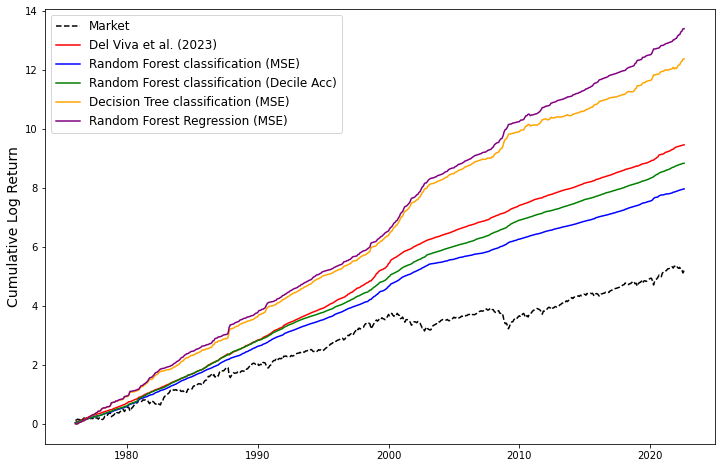

In [85]:
# Plot cumulative log returns for best_models


from matplotlib import lines


plt.figure(figsize=(12, 8))
#for model in best_models:
#    plt.plot(cum_log_ret.index, cum_log_ret[model], label=model)

#plot the 'l_Mkt' from cum_log_ret
plt.plot(cum_log_ret.index, cum_log_ret['l_Mkt'], label='Market', color='black', linestyle='dashed')

# plot 'l_ols_default' from cum_log_ret
plt.plot(cum_log_ret.index, cum_log_ret['l_base_ols_default'], label='Del Viva et al. (2023)', color='red')

# l_RF_reg_roll5_MSE from cum_log_ret
plt.plot(cum_log_ret.index, cum_log_ret['l_RF_class_roll5_MSE'], label='Random Forest classification (MSE)', color='blue')

# l_RF_reg_roll5 from cum_log_ret
plt.plot(cum_log_ret.index, cum_log_ret['l_RF_class_roll5'], label='Random Forest classification (Decile Acc)', color='green')

# plot l_DT_class_roll5_MSE from cum_log_ret
plt.plot(cum_log_ret.index, cum_log_ret['l_DT_reg_roll5_MSE'], label='Decision Tree classification (MSE)', color='orange')

# plot l_RF_reg_roll5_MSE from cum_log_ret
plt.plot(cum_log_ret.index, cum_log_ret['l_RF_reg_roll5_MSE'], label='Random Forest Regression (MSE)', color='purple')



plt.ylabel('Cumulative Log Return', fontsize=14)
plt.legend(fontsize=12)
plt.show()


### From log returns to normal returns

In [86]:
# Copy the DataFrame to keep the date column unchanged
normal_ret = log_ret.copy()

# Apply the conversion to all columns except 'date'
for col in normal_ret.columns:
    if col != 'date':
        normal_ret[col] = np.exp(normal_ret[col]) - 1

# Display the head of the updated DataFrame to verify the changes
normal_ret.head()

,l_ols_default,l_ridge_reg_roll5,l_lasso_reg_roll5,l_DT_reg_roll5,l_RF_reg_roll5,l_Mkt,l_base_ols_default,l_ridge_clas_roll5,l_DT_class_roll5,l_RF_class_roll5,l_lasso_clas_roll5,l_ridge_reg_roll5_MSE,l_lasso_reg_roll5_MSE,l_DT_reg_roll5_MSE,l_RF_reg_roll5_MSE,l_ridge_clas_roll5_MSE,l_DT_class_roll5_MSE,l_RF_class_roll5_MSE,l_lasso_clas_roll5_MSE
date,,,,,,,,,,,,,,,,,,,
1976-01-31,0.030443,0.032248,-0.085951,-0.001281,-0.001266,0.1263,0.039535,0.022482,-0.001281,0.023344,0.023680,0.027975,-0.085951,-0.001281,-0.001266,0.022083,-0.001281,0.023344,-0.001181
1976-02-29,0.015261,0.014575,0.008840,-0.009918,-0.009918,0.0066,0.022362,0.022715,0.024883,0.019715,0.027280,0.023342,0.008840,-0.009918,-0.009918,0.013882,-0.009918,0.019715,0.003720
1976-03-31,0.010497,0.010523,0.005309,0.005947,0.008930,0.0272,0.011892,0.012816,0.013794,0.013456,0.005136,0.011603,0.005309,0.005947,0.007022,0.009977,0.005947,0.013456,0.002116
1976-04-30,0.010684,0.006683,0.002828,0.026945,0.026956,-0.0107,0.007972,0.007129,0.026854,0.010274,0.002820,0.010595,0.002828,0.026945,0.026767,0.007117,0.026945,0.010274,0.002856
1976-05-31,0.020038,0.019607,0.005792,0.025408,0.025408,-0.0097,0.019215,0.017697,0.025362,0.016797,0.017470,0.020071,0.005792,0.025408,0.025379,0.016704,0.025408,0.016797,0.016825


In [87]:
normal_ret.rename(columns={col: col.replace('l_', '') if col != 'date' else col for col in normal_ret.columns}, inplace=True)
normal_ret.head()

,ols_default,ridge_reg_roll5,lasso_reg_roll5,DT_reg_roll5,RF_reg_roll5,Mkt,base_ols_default,ridge_clas_roll5,DT_class_roll5,RF_class_roll5,lasso_clas_roll5,ridge_reg_roll5_MSE,lasso_reg_roll5_MSE,DT_reg_roll5_MSE,RF_reg_roll5_MSE,ridge_clas_roll5_MSE,DT_class_roll5_MSE,RF_class_roll5_MSE,lasso_clas_roll5_MSE
date,,,,,,,,,,,,,,,,,,,
1976-01-31,0.030443,0.032248,-0.085951,-0.001281,-0.001266,0.1263,0.039535,0.022482,-0.001281,0.023344,0.023680,0.027975,-0.085951,-0.001281,-0.001266,0.022083,-0.001281,0.023344,-0.001181
1976-02-29,0.015261,0.014575,0.008840,-0.009918,-0.009918,0.0066,0.022362,0.022715,0.024883,0.019715,0.027280,0.023342,0.008840,-0.009918,-0.009918,0.013882,-0.009918,0.019715,0.003720
1976-03-31,0.010497,0.010523,0.005309,0.005947,0.008930,0.0272,0.011892,0.012816,0.013794,0.013456,0.005136,0.011603,0.005309,0.005947,0.007022,0.009977,0.005947,0.013456,0.002116
1976-04-30,0.010684,0.006683,0.002828,0.026945,0.026956,-0.0107,0.007972,0.007129,0.026854,0.010274,0.002820,0.010595,0.002828,0.026945,0.026767,0.007117,0.026945,0.010274,0.002856
1976-05-31,0.020038,0.019607,0.005792,0.025408,0.025408,-0.0097,0.019215,0.017697,0.025362,0.016797,0.017470,0.020071,0.005792,0.025408,0.025379,0.016704,0.025408,0.016797,0.016825


## Bringing in the market data, factors

In [88]:
# load csv from "C:\Users\tomta\Tomas\School\03_Magistr\02_Business Analytics\10_BA_Thesis\03_Modeling\02_Sign prediction\FF3_clean.csv"
ff3 = pd.read_csv('C:\\Users\\tomta\\Tomas\\School\\03_Magistr\\02_Business Analytics\\10_BA_Thesis\\03_Modeling\\02_Sign prediction\\FF3_clean.csv')
ff5 = pd.read_csv('C:\\Users\\tomta\\Tomas\\School\\03_Magistr\\02_Business Analytics\\10_BA_Thesis\\03_Modeling\\02_Sign prediction\\FF5_clean.csv')

In [89]:
ff3.head()

,date,Mkt-RF,SMB,HML,RF
0,1926-07-31,2.96,-2.56,-2.43,0.22
1,1926-08-31,2.64,-1.17,3.82,0.25
2,1926-09-30,0.36,-1.40,0.13,0.23
3,1926-10-31,-3.24,-0.09,0.70,0.32
4,1926-11-30,2.53,-0.10,-0.51,0.31


In [90]:
ff3['date'] = pd.to_datetime(ff3['date'])
ff5['date'] = pd.to_datetime(ff5['date'])

# rename SMB and HML columns in ff3 to SMB3 and HML3
ff3.rename(columns={'SMB': 'SMB3', 'HML': 'HML3'}, inplace=True)

# rename SMB and HML columns in ff5 to SMB5 and HML5 and RMW and CMA to RMW5 and CMA5
ff5.rename(columns={'SMB': 'SMB5', 'HML': 'HML5', 'RMW': 'RMW5', 'CMA': 'CMA5'}, inplace=True)

# drop the Mkt-RF and RF column from ff5
ff5 = ff5.drop(['Mkt-RF', 'RF'], axis=1)

# divide all columns in ff3 by 100 (except for the date column)
ff3.iloc[:, 1:] = ff3.iloc[:, 1:] / 100


# merge the ff3 and ff5 DataFrames to one dataframe
factors = pd.merge(ff3, ff5, on='date', how='left')

factors.tail()

,date,Mkt-RF,SMB3,HML3,RF,SMB5,HML5,RMW5,CMA5
1165,2023-08-31,-0.0239,-0.0316,-0.0106,0.0045,-0.0365,-0.0106,0.0343,-0.0237
1166,2023-09-30,-0.0524,-0.0251,0.0152,0.0043,-0.0180,0.0152,0.0186,-0.0083
1167,2023-10-31,-0.0319,-0.0387,0.0019,0.0047,-0.0404,0.0019,0.0246,-0.0066
1168,2023-11-30,0.0884,-0.0002,0.0164,0.0044,-0.0012,0.0164,-0.0391,-0.0100
1169,2023-12-31,0.0485,0.0635,0.0494,0.0043,0.0732,0.0494,-0.0307,0.0132


In [91]:
models = normal_ret.columns
models.drop('Mkt')

Index(['ols_default', 'ridge_reg_roll5', 'lasso_reg_roll5', 'DT_reg_roll5',
       'RF_reg_roll5', 'base_ols_default', 'ridge_clas_roll5',
       'DT_class_roll5', 'RF_class_roll5', 'lasso_clas_roll5',
       'ridge_reg_roll5_MSE', 'lasso_reg_roll5_MSE', 'DT_reg_roll5_MSE',
       'RF_reg_roll5_MSE', 'ridge_clas_roll5_MSE', 'DT_class_roll5_MSE',
       'RF_class_roll5_MSE', 'lasso_clas_roll5_MSE'],
      dtype='object')

In [92]:
# merge ff3 to normal_ret on 'date'
normal_ret = normal_ret.merge(factors, on='date', how='inner')

normal_ret.head()

,date,ols_default,ridge_reg_roll5,lasso_reg_roll5,DT_reg_roll5,RF_reg_roll5,Mkt,base_ols_default,ridge_clas_roll5,DT_class_roll5,RF_class_roll5,lasso_clas_roll5,ridge_reg_roll5_MSE,lasso_reg_roll5_MSE,DT_reg_roll5_MSE,RF_reg_roll5_MSE,ridge_clas_roll5_MSE,DT_class_roll5_MSE,RF_class_roll5_MSE,lasso_clas_roll5_MSE,Mkt-RF,SMB3,HML3,RF,SMB5,HML5,RMW5,CMA5
0,1976-01-31,0.030443,0.032248,-0.085951,-0.001281,-0.001266,0.1263,0.039535,0.022482,-0.001281,0.023344,0.023680,0.027975,-0.085951,-0.001281,-0.001266,0.022083,-0.001281,0.023344,-0.001181,0.1216,0.0481,0.0863,0.0047,0.0634,0.0863,-0.0179,0.0228
1,1976-02-29,0.015261,0.014575,0.008840,-0.009918,-0.009918,0.0066,0.022362,0.022715,0.024883,0.019715,0.027280,0.023342,0.008840,-0.009918,-0.009918,0.013882,-0.009918,0.019715,0.003720,0.0032,0.0706,0.0587,0.0034,0.0799,0.0587,-0.0264,0.0387
2,1976-03-31,0.010497,0.010523,0.005309,0.005947,0.008930,0.0272,0.011892,0.012816,0.013794,0.013456,0.005136,0.011603,0.005309,0.005947,0.007022,0.009977,0.005947,0.013456,0.002116,0.0232,-0.0116,-0.0012,0.0040,-0.0138,-0.0012,-0.0033,0.0096
3,1976-04-30,0.010684,0.006683,0.002828,0.026945,0.026956,-0.0107,0.007972,0.007129,0.026854,0.010274,0.002820,0.010595,0.002828,0.026945,0.026767,0.007117,0.026945,0.010274,0.002856,-0.0149,-0.0011,-0.0016,0.0042,0.0008,-0.0016,0.0040,-0.0110
4,1976-05-31,0.020038,0.019607,0.005792,0.025408,0.025408,-0.0097,0.019215,0.017697,0.025362,0.016797,0.017470,0.020071,0.005792,0.025408,0.025379,0.016704,0.025408,0.016797,0.016825,-0.0134,-0.0123,-0.0136,0.0037,-0.0110,-0.0136,0.0246,-0.0141


### Make some plots - return distributions

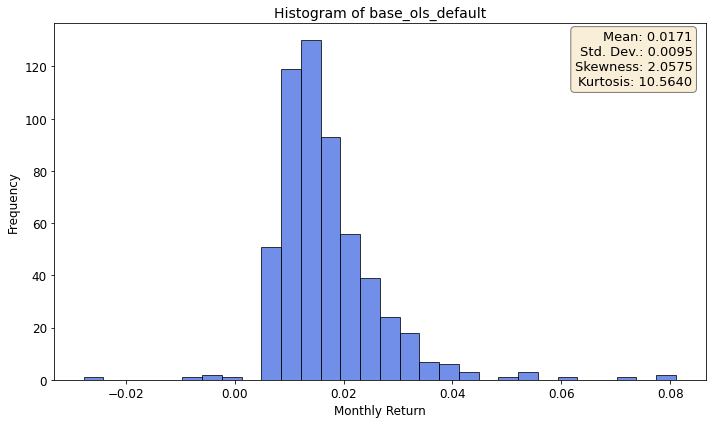

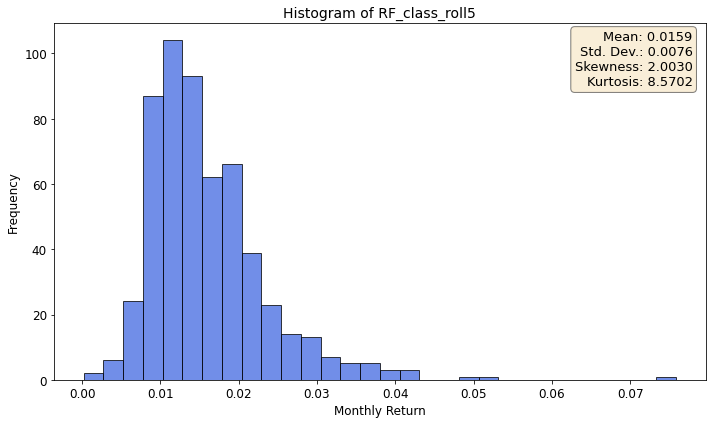

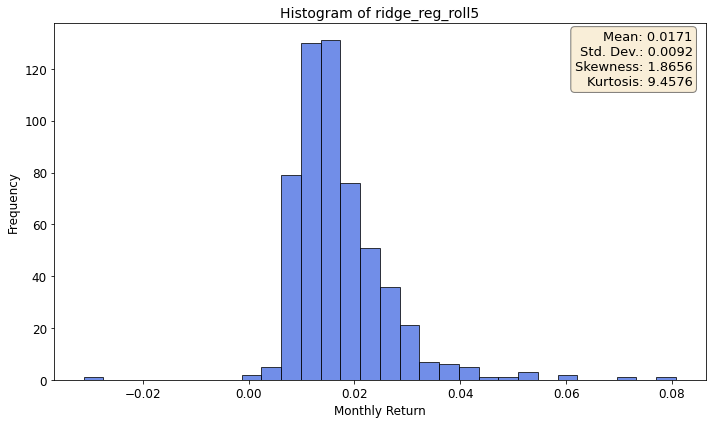

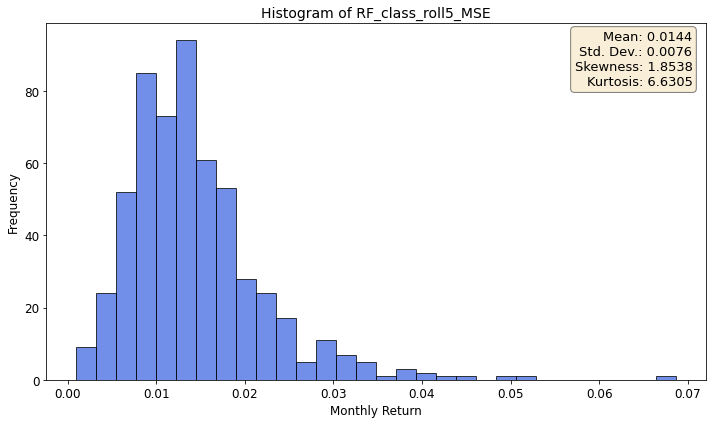

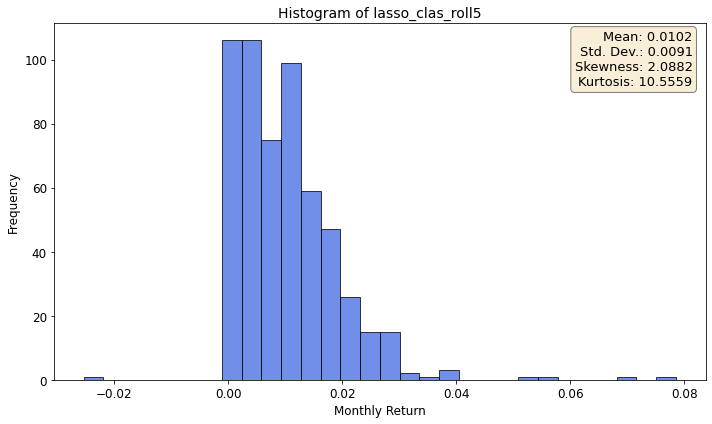

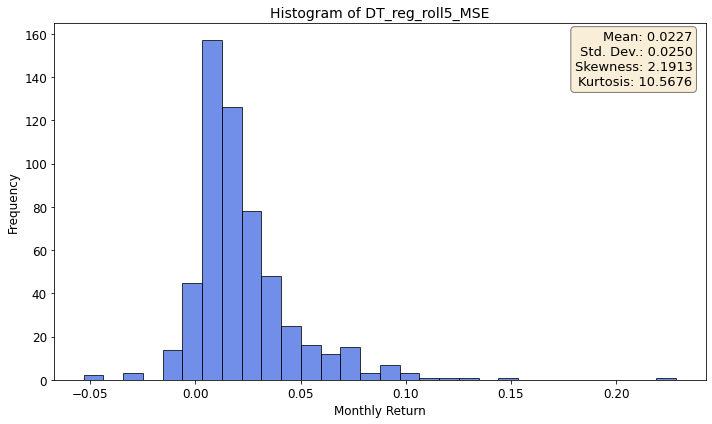

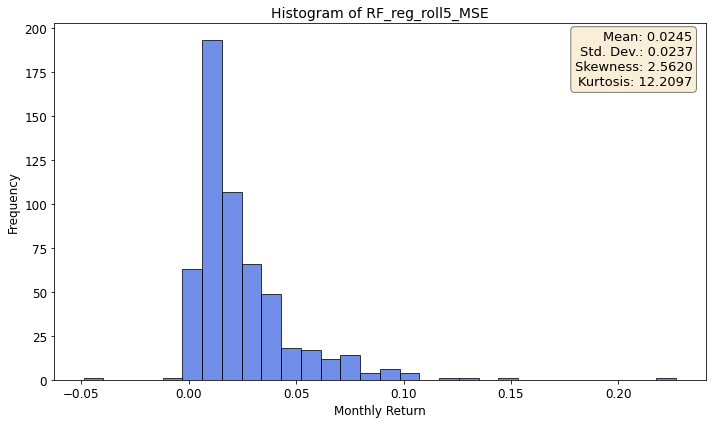

In [93]:
import matplotlib.pyplot as plt
import pandas as pd
from scipy.stats import skew, kurtosis

# Assuming 'normal_ret' is your DataFrame and it's already loaded

def plot_histograms_separately(df, columns, bins=30, color='royalblue'):
    for column in columns:
        if column not in df.columns:
            print(f"Column '{column}' not found in DataFrame.")
            continue

        fig, ax = plt.subplots(figsize=(10, 6))
        values = df[column] 
        mean_val = values.mean()
        std_dev_val = values.std()
        skewness_val = skew(values)
        kurtosis_val = kurtosis(values)

        ax.hist(values, bins=bins, alpha=0.75, color=color, edgecolor='black')
        ax.set_title(f'Histogram of {column}', fontsize=14)
        ax.set_xlabel('Monthly Return', fontsize=12)
        ax.set_ylabel('Frequency', fontsize=12)
        ax.xaxis.set_tick_params(labelsize=12)
        ax.yaxis.set_tick_params(labelsize=12)


        # Annotating the plot with statistical values
        stats_text = f'Mean: {mean_val:.4f}\nStd. Dev.: {std_dev_val:.4f}\nSkewness: {skewness_val:.4f}\nKurtosis: {kurtosis_val:.4f}'
        ax.text(0.98, 0.98, stats_text, transform=ax.transAxes, verticalalignment='top', horizontalalignment='right', fontsize=13, bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5))

        plt.tight_layout()
        plt.show()



selected_columns = ['base_ols_default', 'RF_class_roll5' , 'ridge_reg_roll5',  'RF_class_roll5_MSE', 'lasso_clas_roll5', 'DT_reg_roll5_MSE', 'RF_reg_roll5_MSE']

plot_histograms_separately(normal_ret, selected_columns)


In [94]:
# for each column, calculate the average of the column and store in a new DataFrame

avg_ret = normal_ret.mean()

# rename the column to 'avg_ret' and index to 'model'
avg_ret = avg_ret.to_frame().reset_index()
avg_ret.columns = ['model', 'avg_ret']

# round the values in the 'avg_ret' column to 3 decimal places
avg_ret['avg_ret'] = avg_ret['avg_ret'].round(3)


avg_ret.head()

<ipython-input-94-fcce1330845f>:3: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  avg_ret = normal_ret.mean()


,model,avg_ret
0,ols_default,0.017
1,ridge_reg_roll5,0.017
2,lasso_reg_roll5,0.005
3,DT_reg_roll5,0.022
4,RF_reg_roll5,0.024


In [95]:
excess_ret = normal_ret.copy()

# Calculate excess return (i.e. subtract the RF column) for columns in 'models' list
for model in models:
    excess_ret[model] = excess_ret[model] - excess_ret['RF']


excess_ret.head()


,date,ols_default,ridge_reg_roll5,lasso_reg_roll5,DT_reg_roll5,RF_reg_roll5,Mkt,base_ols_default,ridge_clas_roll5,DT_class_roll5,RF_class_roll5,lasso_clas_roll5,ridge_reg_roll5_MSE,lasso_reg_roll5_MSE,DT_reg_roll5_MSE,RF_reg_roll5_MSE,ridge_clas_roll5_MSE,DT_class_roll5_MSE,RF_class_roll5_MSE,lasso_clas_roll5_MSE,Mkt-RF,SMB3,HML3,RF,SMB5,HML5,RMW5,CMA5
0,1976-01-31,0.025743,0.027548,-0.090651,-0.005981,-0.005966,0.1216,0.034835,0.017782,-0.005981,0.018644,0.018980,0.023275,-0.090651,-0.005981,-0.005966,0.017383,-0.005981,0.018644,-0.005881,0.1216,0.0481,0.0863,0.0047,0.0634,0.0863,-0.0179,0.0228
1,1976-02-29,0.011861,0.011175,0.005440,-0.013318,-0.013318,0.0032,0.018962,0.019315,0.021483,0.016315,0.023880,0.019942,0.005440,-0.013318,-0.013318,0.010482,-0.013318,0.016315,0.000320,0.0032,0.0706,0.0587,0.0034,0.0799,0.0587,-0.0264,0.0387
2,1976-03-31,0.006497,0.006523,0.001309,0.001947,0.004930,0.0232,0.007892,0.008816,0.009794,0.009456,0.001136,0.007603,0.001309,0.001947,0.003022,0.005977,0.001947,0.009456,-0.001884,0.0232,-0.0116,-0.0012,0.0040,-0.0138,-0.0012,-0.0033,0.0096
3,1976-04-30,0.006484,0.002483,-0.001372,0.022745,0.022756,-0.0149,0.003772,0.002929,0.022654,0.006074,-0.001380,0.006395,-0.001372,0.022745,0.022567,0.002917,0.022745,0.006074,-0.001344,-0.0149,-0.0011,-0.0016,0.0042,0.0008,-0.0016,0.0040,-0.0110
4,1976-05-31,0.016338,0.015907,0.002092,0.021708,0.021708,-0.0134,0.015515,0.013997,0.021662,0.013097,0.013770,0.016371,0.002092,0.021708,0.021679,0.013004,0.021708,0.013097,0.013125,-0.0134,-0.0123,-0.0136,0.0037,-0.0110,-0.0136,0.0246,-0.0141


In [96]:
# save the excess_ret DataFrame to a .dta file
excess_ret.to_csv('base_excess_ret.csv', index=False)

### Calculating Sharpe Ratios and Abnormal Returns


In [97]:
import statsmodels.api as sm

In [98]:
models = excess_ret.columns
models = models.drop(['date', 'Mkt', 'SMB3', 'HML3', 'RF', 'SMB5', 'HML5', 'RMW5', 'CMA5', 'Mkt-RF'])

# Initialize DataFrame to hold all results
backtest = pd.DataFrame(columns=['Model', 'Ann_Sharpe', 'CAPM_a', 'CAPM_p', 'FF3_a', 'FF3_p', 'FF5_a', 'FF5_p'])

# Prepare X variables for CAPM and Three-Factor models outside the loop
X_capm = sm.add_constant(excess_ret['Mkt-RF'])  # CAPM
X_ff3 = sm.add_constant(excess_ret[['Mkt-RF', 'SMB3', 'HML3']])  # Three-Factor

# Drop rows with NaN values in Five-Factor model variables
X_ff5_clean = excess_ret[['Mkt-RF', 'SMB5', 'HML5', 'RMW5', 'CMA5']].dropna()
X_ff5 = sm.add_constant(X_ff5_clean)  # Five-Factor

for model in models:
    # Assuming y might contain NaNs, drop them for alignment
    y = excess_ret[model]
    
    # Ensure alignment of y with each X variable
    # CAPM model fit
    aligned_X_capm = X_capm.loc[y.index]
    capm_results = sm.OLS(y, aligned_X_capm).fit()
    
    # Three-Factor model fit
    aligned_X_ff3 = X_ff3.loc[y.index]
    ff3_results = sm.OLS(y, aligned_X_ff3).fit()
    
    # Five-Factor model fit, ensuring alignment with the clean X_ff5 index
    aligned_X_ff5 = X_ff5.loc[X_ff5.index.intersection(y.index)]
    y_aligned_ff5 = y.loc[aligned_X_ff5.index]
    ff5_results = sm.OLS(y_aligned_ff5, aligned_X_ff5).fit()
    
    # Calculate and round the annualized Sharpe ratio
    mean_excess_return = y.mean()
    std_dev_excess_returns = y.std()
    ann_sharpe = round((mean_excess_return/std_dev_excess_returns) * np.sqrt(12), 2)  # Square root of 12 for monthly data
    
    # Round alpha and p-values
    capm_a = round(capm_results.params[0], 3)
    capm_p = round(capm_results.pvalues[0], 3)
    ff3_a = round(ff3_results.params[0], 3)
    ff3_p = round(ff3_results.pvalues[0], 3)
    ff5_a = round(ff5_results.params[0], 3)
    ff5_p = round(ff5_results.pvalues[0], 3)
    
    # Append results to the DataFrame
    backtest = backtest.append({
        'Model': model,
        'Ann_Sharpe': ann_sharpe,
        'CAPM_a': capm_a,
        'CAPM_p': capm_p,
        'FF3_a': ff3_a,
        'FF3_p': ff3_p,
        'FF5_a': ff5_a,
        'FF5_p': ff5_p,
    }, ignore_index=True)


# drop the row where the model is 'Mkt'
#backtest = backtest[backtest['Model'] != 'Mkt']

# Display the compiled results
backtest.head(10)


,Model,Ann_Sharpe,CAPM_a,CAPM_p,FF3_a,FF3_p,FF5_a,FF5_p
0,ols_default,0.513,0.013,0.0,0.013,0.0,0.013,0.0
1,ridge_reg_roll5,0.515,0.013,0.0,0.013,0.0,0.013,0.0
2,lasso_reg_roll5,0.064,0.002,0.0,0.002,0.0,0.002,0.0
3,DT_reg_roll5,0.264,0.022,0.0,0.022,0.0,0.022,0.0
4,RF_reg_roll5,0.298,0.024,0.0,0.024,0.0,0.024,0.0
5,base_ols_default,0.494,0.013,0.0,0.013,0.0,0.013,0.0
6,ridge_clas_roll5,0.393,0.010,0.0,0.010,0.0,0.010,0.0
7,DT_class_roll5,0.056,0.011,0.0,0.010,0.0,0.010,0.0
8,RF_class_roll5,0.574,0.012,0.0,0.012,0.0,0.012,0.0
9,lasso_clas_roll5,0.255,0.007,0.0,0.007,0.0,0.007,0.0


In [99]:
backtest.sort_values('Ann_Sharpe', ascending=False, inplace=True)

In [100]:
# round the total_cum_logret column to 4 decimal places
final_log_ret_df['total_cum_logret'] = final_log_ret_df['total_cum_logret'].round(3)

# if the value in the column "model" of final_log_ret_df starts with "l_" then remove the "l_" from the value
final_log_ret_df['model'] = final_log_ret_df['model'].apply(lambda x: x[2:] if x.startswith('l_') else x)

# merge with avg_ret DataFrame on the 'model' column
backtest = backtest.merge(avg_ret, left_on='Model', right_on='model', how='left')

# remove the model column
backtest.drop('model', axis=1, inplace=True)

# drop row where Model is ols_default_x	
backtest = backtest[backtest['Model'] != 'ols_default_x']


backtest.head(50)



,Model,Ann_Sharpe,CAPM_a,CAPM_p,FF3_a,FF3_p,FF5_a,FF5_p,avg_ret
0,RF_class_roll5,0.574,0.012,0.0,0.012,0.0,0.012,0.0,0.016
1,ridge_reg_roll5_MSE,0.517,0.013,0.0,0.013,0.0,0.013,0.0,0.017
2,ridge_reg_roll5,0.515,0.013,0.0,0.013,0.0,0.013,0.0,0.017
3,ols_default,0.513,0.013,0.0,0.013,0.0,0.013,0.0,0.017
4,RF_class_roll5_MSE,0.507,0.011,0.0,0.011,0.0,0.011,0.0,0.014
5,base_ols_default,0.494,0.013,0.0,0.013,0.0,0.013,0.0,0.017
6,ridge_clas_roll5,0.393,0.010,0.0,0.010,0.0,0.010,0.0,0.014
7,RF_reg_roll5_MSE,0.307,0.024,0.0,0.024,0.0,0.024,0.0,0.025
8,RF_reg_roll5,0.298,0.024,0.0,0.024,0.0,0.024,0.0,0.024
9,DT_reg_roll5_MSE,0.267,0.022,0.0,0.022,0.0,0.023,0.0,0.023


In [101]:
# merge the final_log_ret_df and backtest DataFrames on the 'model' column
backtest = backtest.merge(final_log_ret_df, left_on='Model', right_on='model', how='left')

# remove the model column
backtest.drop('model', axis=1, inplace=True)

backtest.head(10)

,Model,Ann_Sharpe,CAPM_a,CAPM_p,FF3_a,FF3_p,FF5_a,FF5_p,avg_ret,total_cum_logret,Type,Metric,Algorithm
0,RF_class_roll5,0.574,0.012,0.0,0.012,0.0,0.012,0.0,0.016,8.826,class,acc,RF
1,ridge_reg_roll5_MSE,0.517,0.013,0.0,0.013,0.0,0.013,0.0,0.017,9.316,reg,mse,ridge
2,ridge_reg_roll5,0.515,0.013,0.0,0.013,0.0,0.013,0.0,0.017,9.476,reg,acc,ridge
3,ols_default,0.513,0.013,0.0,0.013,0.0,0.013,0.0,0.017,9.263,reg,acc,ols
4,RF_class_roll5_MSE,0.507,0.011,0.0,0.011,0.0,0.011,0.0,0.014,7.960,class,mse,RF
5,base_ols_default,0.494,0.013,0.0,0.013,0.0,0.013,0.0,0.017,9.453,reg,acc,ols
6,ridge_clas_roll5,0.393,0.010,0.0,0.010,0.0,0.010,0.0,0.014,7.515,class,acc,ridge
7,RF_reg_roll5_MSE,0.307,0.024,0.0,0.024,0.0,0.024,0.0,0.025,13.388,reg,mse,RF
8,RF_reg_roll5,0.298,0.024,0.0,0.024,0.0,0.024,0.0,0.024,13.114,reg,acc,RF
9,DT_reg_roll5_MSE,0.267,0.022,0.0,0.022,0.0,0.023,0.0,0.023,12.363,reg,mse,DT


In [102]:
# save the backtest into parquet
backtest.to_parquet('backtest.parquet')

In [103]:
# sort the backtest using Ann_sharpe in descending order
backtest.sort_values('Ann_Sharpe', ascending=False, inplace=True)
backtest.head(30)

,Model,Ann_Sharpe,CAPM_a,CAPM_p,FF3_a,FF3_p,FF5_a,FF5_p,avg_ret,total_cum_logret,Type,Metric,Algorithm
0,RF_class_roll5,0.574,0.012,0.0,0.012,0.0,0.012,0.0,0.016,8.826,class,acc,RF
1,ridge_reg_roll5_MSE,0.517,0.013,0.0,0.013,0.0,0.013,0.0,0.017,9.316,reg,mse,ridge
2,ridge_reg_roll5,0.515,0.013,0.0,0.013,0.0,0.013,0.0,0.017,9.476,reg,acc,ridge
3,ols_default,0.513,0.013,0.0,0.013,0.0,0.013,0.0,0.017,9.263,reg,acc,ols
4,RF_class_roll5_MSE,0.507,0.011,0.0,0.011,0.0,0.011,0.0,0.014,7.960,class,mse,RF
5,base_ols_default,0.494,0.013,0.0,0.013,0.0,0.013,0.0,0.017,9.453,reg,acc,ols
6,ridge_clas_roll5,0.393,0.010,0.0,0.010,0.0,0.010,0.0,0.014,7.515,class,acc,ridge
7,RF_reg_roll5_MSE,0.307,0.024,0.0,0.024,0.0,0.024,0.0,0.025,13.388,reg,mse,RF
8,RF_reg_roll5,0.298,0.024,0.0,0.024,0.0,0.024,0.0,0.024,13.114,reg,acc,RF
10,DT_class_roll5_MSE,0.267,0.022,0.0,0.022,0.0,0.023,0.0,0.023,12.364,class,mse,DT


In [109]:
# print the average annualized Sharpe ratio for each type and method
print(backtest.groupby(['Type'])['Ann_Sharpe'].mean())
print(backtest.groupby(['Type'])['CAPM_a'].mean())
print(backtest['Ann_Sharpe'].mean())

print(backtest['CAPM_a'].mean())

Type
class    0.302375
reg      0.330300
Name: Ann_Sharpe, dtype: float64
Type
class    0.010125
reg      0.014800
Name: CAPM_a, dtype: float64
0.31788888888888894
0.012722222222222222


In [105]:
# Convert categorical variables into dummy variables
backtest_dummies = pd.get_dummies(backtest, columns=['Type', 'Metric', 'Algorithm'])

# Define the base formula components excluding CAPM, FF3, and FF5 related columns
base_formula_components = ['Type', 'Metric', 'Algorithm']

# Construct the formula for Sharpe Ratio regression
formula_sharpe = 'Ann_Sharpe ~ ' + ' + '.join([f'C({component})' for component in base_formula_components])

# Construct the formula for Total Cumulative Logarithmic Return regression
formula_logret = 'total_cum_logret ~ ' + ' + '.join([f'C({component})' for component in base_formula_components])

# Perform the regression for Sharpe Ratio
model_sharpe = smf.ols(formula=formula_sharpe, data=backtest).fit()

# Perform the regression for Total Cumulative Logarithmic Return
model_logret = smf.ols(formula=formula_logret, data=backtest).fit()

# Print the summary tables for both regressions
print("Regression for Sharpe Ratio:\n", model_sharpe.summary())
print("\nRegression for Total Cumulative Logarithmic Return:\n", model_logret.summary())


Regression for Sharpe Ratio:
                             OLS Regression Results                            
Dep. Variable:             Ann_Sharpe   R-squared:                       0.657
Model:                            OLS   Adj. R-squared:                  0.469
Method:                 Least Squares   F-statistic:                     3.507
Date:                Thu, 07 Mar 2024   Prob (F-statistic):             0.0344
Time:                        15:15:21   Log-Likelihood:                 16.266
No. Observations:                  18   AIC:                            -18.53
Df Residuals:                      11   BIC:                            -12.30
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
                            coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------


c:\Users\tomta\anaconda3\lib\site-packages\scipy\stats\_stats_py.py:1736: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=18
  warnings.warn("kurtosistest only valid for n>=20 ... continuing "
c:\Users\tomta\anaconda3\lib\site-packages\scipy\stats\_stats_py.py:1736: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=18
  warnings.warn("kurtosistest only valid for n>=20 ... continuing "


In [106]:
backtest = backtest.merge(metrics_df[['Accuracy', 'MAE', 'MSE']], left_on='Model', right_index=True, how='left')
backtest.rename(columns={'Accuracy': 'Acc_tot', 'MAE': 'MAE_tot', 'MSE': 'MSE_tot'}, inplace=True)
backtest = backtest.merge(metrics_decile[['Accuracy', 'MAE', 'MSE']], left_on='Model', right_index=True, how='left')
backtest.rename(columns={'Accuracy': 'Acc_dec', 'MAE': 'MAE_dec', 'MSE': 'MSE_dec'}, inplace=True)
backtest.head()

,Model,Ann_Sharpe,CAPM_a,CAPM_p,FF3_a,FF3_p,FF5_a,FF5_p,avg_ret,total_cum_logret,Type,Metric,Algorithm,Acc_tot,MAE_tot,MSE_tot,Acc_dec,MAE_dec,MSE_dec
0,RF_class_roll5,0.574,0.012,0.0,0.012,0.0,0.012,0.0,0.016,8.826,class,acc,RF,0.971124,0.126338,0.033426,0.998675,0.035036,0.002771
1,ridge_reg_roll5_MSE,0.517,0.013,0.0,0.013,0.0,0.013,0.0,0.017,9.316,reg,mse,ridge,0.838982,0.338617,0.150509,0.981057,0.211130,0.098119
2,ridge_reg_roll5,0.515,0.013,0.0,0.013,0.0,0.013,0.0,0.017,9.476,reg,acc,ridge,0.828993,0.342293,0.150194,0.983573,0.200164,0.081897
3,ols_default,0.513,0.013,0.0,0.013,0.0,0.013,0.0,0.017,9.263,reg,acc,ols,0.863516,0.331614,0.156884,0.981910,0.216044,0.179753
4,RF_class_roll5_MSE,0.507,0.011,0.0,0.011,0.0,0.011,0.0,0.014,7.960,class,mse,RF,0.971152,0.111654,0.030291,0.998701,0.026905,0.002091


In [107]:
# OLS: Ann_Sharpe ~ Acc_tot
model_acc_tot = smf.ols(formula='Ann_Sharpe ~ Acc_tot', data=backtest).fit()

# OLS: Ann_Sharpe ~ Acc_dec
model_acc_dec = smf.ols(formula='Ann_Sharpe ~ Acc_dec', data=backtest).fit()

# OLS: Ann_Sharpe ~ MSE_tot
model_mse_tot = smf.ols(formula='Ann_Sharpe ~ MSE_tot', data=backtest).fit()

# OLS: Ann_Sharpe ~ MSE_dec
model_mse_dec = smf.ols(formula='Ann_Sharpe ~ MSE_dec', data=backtest).fit()

# print the summary tables for both regressions
print("Regression for Ann_Sharpe ~ Acc_tot:\n", model_acc_tot.summary())
print("\nRegression for Ann_Sharpe ~ Acc_dec:\n", model_acc_dec.summary())
print("\nRegression for Ann_Sharpe ~ MSE_tot:\n", model_mse_tot.summary())
print("\nRegression for Ann_Sharpe ~ MSE_dec:\n", model_mse_dec.summary())



Regression for Ann_Sharpe ~ Acc_tot:
                             OLS Regression Results                            
Dep. Variable:             Ann_Sharpe   R-squared:                       0.001
Model:                            OLS   Adj. R-squared:                 -0.061
Method:                 Least Squares   F-statistic:                   0.01781
Date:                Thu, 07 Mar 2024   Prob (F-statistic):              0.895
Time:                        15:15:22   Log-Likelihood:                 6.6540
No. Observations:                  18   AIC:                            -9.308
Df Residuals:                      16   BIC:                            -7.527
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     

c:\Users\tomta\anaconda3\lib\site-packages\scipy\stats\_stats_py.py:1736: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=18
  warnings.warn("kurtosistest only valid for n>=20 ... continuing "
c:\Users\tomta\anaconda3\lib\site-packages\scipy\stats\_stats_py.py:1736: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=18
  warnings.warn("kurtosistest only valid for n>=20 ... continuing "
c:\Users\tomta\anaconda3\lib\site-packages\scipy\stats\_stats_py.py:1736: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=18
  warnings.warn("kurtosistest only valid for n>=20 ... continuing "
c:\Users\tomta\anaconda3\lib\site-packages\scipy\stats\_stats_py.py:1736: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=18
  warnings.warn("kurtosistest only valid for n>=20 ... continuing "


In [108]:
# OLS: total_cum_logret ~ Acc_tot
model_logret_acc_tot = smf.ols(formula='total_cum_logret ~ Acc_tot', data=backtest).fit()

# OLS: total_cum_logret ~ Acc_dec
model_logret_acc_dec = smf.ols(formula='total_cum_logret ~ Acc_dec', data=backtest).fit()

# OLS: total_cum_logret ~ MSE_tot
model_logret_mse_tot = smf.ols(formula='total_cum_logret ~ MSE_tot', data=backtest).fit()

# OLS: total_cum_logret ~ MSE_dec
model_logret_mse_dec = smf.ols(formula='total_cum_logret ~ MSE_dec', data=backtest).fit()

# print the summary tables for both regressions
print("Regression for total_cum_logret ~ Acc_tot:\n", model_logret_acc_tot.summary())
print("\nRegression for total_cum_logret ~ Acc_dec:\n", model_logret_acc_dec.summary())
print("\nRegression for total_cum_logret ~ MSE_tot:\n", model_logret_mse_tot.summary())
print("\nRegression for total_cum_logret ~ MSE_dec:\n", model_logret_mse_dec.summary())


c:\Users\tomta\anaconda3\lib\site-packages\scipy\stats\_stats_py.py:1736: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=18
  warnings.warn("kurtosistest only valid for n>=20 ... continuing "
c:\Users\tomta\anaconda3\lib\site-packages\scipy\stats\_stats_py.py:1736: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=18
  warnings.warn("kurtosistest only valid for n>=20 ... continuing "


Regression for total_cum_logret ~ Acc_tot:
                             OLS Regression Results                            
Dep. Variable:       total_cum_logret   R-squared:                       0.221
Model:                            OLS   Adj. R-squared:                  0.172
Method:                 Least Squares   F-statistic:                     4.527
Date:                Thu, 07 Mar 2024   Prob (F-statistic):             0.0493
Time:                        15:15:22   Log-Likelihood:                -46.153
No. Observations:                  18   AIC:                             96.31
Df Residuals:                      16   BIC:                             98.09
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercep

c:\Users\tomta\anaconda3\lib\site-packages\scipy\stats\_stats_py.py:1736: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=18
  warnings.warn("kurtosistest only valid for n>=20 ... continuing "
c:\Users\tomta\anaconda3\lib\site-packages\scipy\stats\_stats_py.py:1736: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=18
  warnings.warn("kurtosistest only valid for n>=20 ... continuing "
